## Luck vs. Skill (Global Funds Edition)

Goal of this notebook is to test out the tools I made in the python file `luck_v_skill.py`, as well as try out the original global fund data. This uses a 3 factor KAPM model to evaluate alphas.

In [1]:
import sys
sys.path.insert(0, '../src')

from luck_v_skill import *
%load_ext autoreload
%autoreload 2

In [2]:
# let's me save a jupyter notebook from a code cell
from IPython.display import Javascript

script = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''

def notebook_save():
    Javascript(script)
    print('This notebook has been saved')

In [3]:
# Dataset is local, not on github
funds = pd.read_csv('../data/global_funds.csv',parse_dates=['Dates'],index_col=['Dates'])
factors = pd.read_csv('../data/global_factors.csv',parse_dates=['Dates'],index_col=['Dates'])
    
funds.shape,factors.shape

((240, 193), (240, 4))

In [4]:
# select columns of interest
# CAREFUL picking factors...multicollinearity is not fun
factor_cols=['WLRF','SMB','HML','RF']
factors = factors[factor_cols]

### Initial Simulation (standard deviation alpha = 0)

In [5]:
# This code cell runs the data through the AlphaEvaluator object found in
# the luck_v_skill.py file. Creates tables of actual alpha percentiles vs
# simulated alpha percentiles with increasing standard deviation asssumptions
# about injected alpha. The first operation assumes std_alpha = 0.

#----------------------------------------------------------------------------
# OUTPUT PARAMETERS
#----------------------------------------------------------------------------
top_n = 10 # look at top 10 and bottom ten funds, in addition to percentiles
pct_range = np.arange(1,10)/10 # percentiles to consider.  0 < x < 1
verbose = True # keep track of where in program we are at
min_obs = 120 # funds must have at least this many obs to be considered
sim_cutoff = 100 # minimum non-NaN obs in sim_matrix obs for regression
n_simulations = 1000 # number of simulations to run
random_seed = 2 # seed the random number generator here
std_range = np.arange(1,21)/20 # standard deviations of alpha to simulate
n_std = len(std_range) + 1 # number of extra standard deviations evaluating


#----------------------------------------------------------------------------
# START
#----------------------------------------------------------------------------
# Time the program
start_time = time.time()
if verbose:
    title_print("Standard Deviation {} of {}".format(1,n_std))

# initialize instance of the AlphaEvaluator with fund and factor data
AEV = AlphaEvaluator(fund_data=funds,factor_data=factors)

# calculates original coefficients, standard errors, and t-stats
AEV.fit(min_obs=min_obs)

# runs simulations and populates simulated coeff, SE, and tstat matrices
AEV.simulate(n_simulations=n_simulations,random_seed=random_seed,sim_std=0,
             sim_cutoff=sim_cutoff,verbose=verbose)

# populates percentile tables for alpha and t(alpha)
AEV.get_percentiles(pct_range=pct_range,verbose=verbose,top_n=top_n)
data_a, data_t = AEV.data_a.copy(), AEV.data_t.copy()

# Rename data columns
data_a.columns = ['Actual','Sim Avg (0.00)', '%<Act (0.00)']
data_t.columns = ['Actual','Sim Avg (0.00)', '%<Act (0.00)']

--------------------------
Standard Deviation 1 of 21
--------------------------
Annual standard deviation: 0.00, Standard deviation alpha: 0.00
Starting 125,000 regressions...
Simulations complete in 54.36 seconds!
Calculating percentiles of simulations... Populating data tables... Done!


### Plots

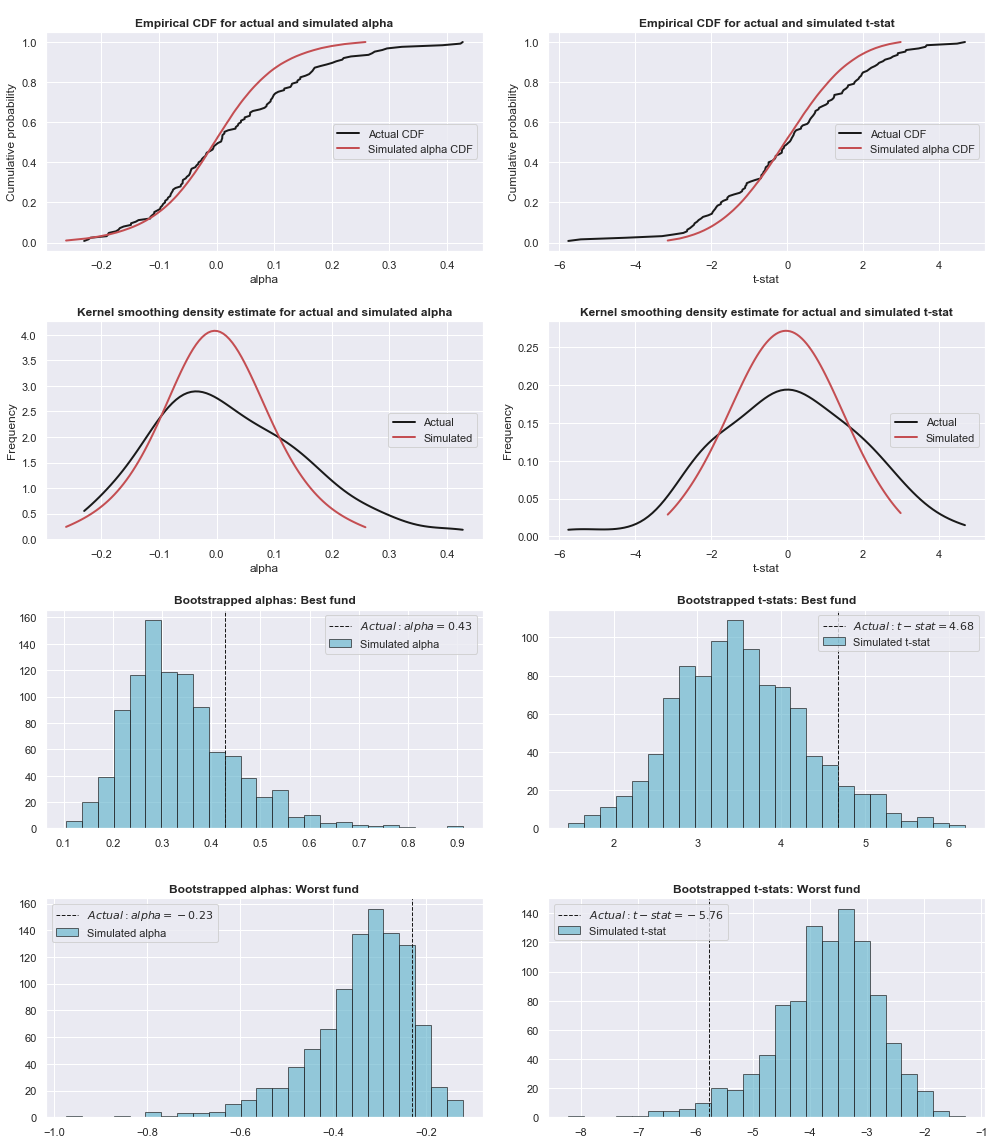

In [6]:
fig, axes = AEV.plot(plot_type=['cdf','kde','hist'],
                     statistic=['alpha','t-stat'],
                     fund=[-1,0])
plt.tight_layout()
plt.savefig('../charts/Global-3factor-plots.png')

### More Simulations

In [7]:
# fill data with more simulations
for i,stdev in enumerate(std_range):
    if verbose:
        title_print("Standard Deviation {} of {}".format(i+2,n_std))
    
    # Rerun simulation with new standard deviation injection for alpha
    AEV.simulate(n_simulations=n_simulations,random_seed=random_seed,
                 sim_std=stdev,sim_cutoff=sim_cutoff,verbose=verbose)
    
    # Update Percentile Data
    AEV.get_percentiles(pct_range=pct_range,verbose=True,top_n=top_n)
    
    # Populate Alpha Percentile Table
    data_a['Sim Avg ({:.2f})'.format(stdev)] = AEV.data_a['Sim Avg']
    data_a['%<Act ({:.2f})'.format(stdev)] = AEV.data_a['%<Act']
    
    # Populate t-statistics Percentile Table
    data_t['Sim Avg ({:.2f})'.format(stdev)] = AEV.data_t['Sim Avg']
    data_t['%<Act ({:.2f})'.format(stdev)] = AEV.data_t['%<Act']


#----------------------------------------------------------------------------
# END
#----------------------------------------------------------------------------

# calculate time elapsed for program and print    
t_diff = time.time()-start_time
minutes = int(np.floor(t_diff/60))
seconds = t_diff - 60*minutes
if verbose:
    print("DONE!")
    print("{} minutes and {:.2f} seconds elapsed for this program".format(minutes,seconds))

--------------------------
Standard Deviation 2 of 21
--------------------------
Annual standard deviation: 0.05, Standard deviation alpha: 0.01
Starting 125,000 regressions...
Simulations complete in 54.72 seconds!
Calculating percentiles of simulations... Populating data tables... Done!
--------------------------
Standard Deviation 3 of 21
--------------------------
Annual standard deviation: 0.10, Standard deviation alpha: 0.03
Starting 125,000 regressions...
Simulations complete in 51.63 seconds!
Calculating percentiles of simulations... Populating data tables... Done!
--------------------------
Standard Deviation 4 of 21
--------------------------
Annual standard deviation: 0.15, Standard deviation alpha: 0.04
Starting 125,000 regressions...
Simulations complete in 50.54 seconds!
Calculating percentiles of simulations... Populating data tables... Done!
--------------------------
Standard Deviation 5 of 21
--------------------------
Annual standard deviation: 0.20, Standard deviati

In [8]:
data_a.to_csv('../tables/Global-3factor-alphas.csv')
data_t.to_csv('../tables/Global-3factor-tstats.csv')

In [9]:
data_a.shape, data_t.shape

((29, 43), (29, 43))

In [10]:
notebook_save()

This notebook has been saved
